https://jp.tradingview.com/script/Iko0E2kL-Nadaraya-Watson-Envelope-LUX/

https://www.tradingview.com/chart/ETHUSD/uQCb82ML-How-to-create-simple-web-hook-to-send-alerts-to-Telegram/

https://www.youtube.com/watch?v=jm9pQtwSmxI


https://replit.com/@LowVincent1/Tradingview-Telegram-Bot#telegrambot.py

In [232]:
import math
import glob
import pandas as pd
import mplfinance as mpf
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from Trader import Trader

## Base Code

In [114]:
data_paths = glob.glob('data/2022/*/bchusdt.{timeframe}*'.format(timeframe='1min'))
data = pd.read_csv(data_paths[0], index_col='Open time', usecols=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume'])

In [115]:
data.index = pd.to_datetime(data.index)
data = data.astype({'Open':'float32', 'High':'float32', 'Low':'float32', 'Close':'float32', 'Volume': 'float32'})

In [116]:
length = 1000
bandwitdh = 2
multiple = 2

data = data.tail(length)
olhc = data.values[::1]
src = data.Close.values[::1]

In [117]:
long_signal = [np.nan]
short_signal = [np.nan]

y = []
sum_e = 0
for i in tqdm(range(length)):
    s = 0
    sw = 0
    
    for j in range(length):
        w = math.exp(-math.pow(i-j, 2) / (bandwitdh*bandwitdh*2))
        s += src[j] * w
        sw += w
        
    y2 = s / sw
    sum_e += abs(src[i] - y2)
    y.append(y2)
    
mae = sum_e / length * multiple

for i in range(1, length-1):
    y2 = y[i]
    y1 = y[i-1]
    
    if src[i] > y1 + mae and src[i+1] < y1 + mae:
        short_signal.append(olhc[i][1] * 1.001)
        long_signal.append(np.nan)
        continue
        
    if src[i] < y1 - mae and src[i+1] > y1 - mae:
        long_signal.append(olhc[i][2] * 0.999)
        short_signal.append(np.nan)
        continue
        
    long_signal.append(np.nan)
    short_signal.append(np.nan)

long_signal.append(np.nan)
short_signal.append(np.nan)
    
# long_signal = long_signal[::-1]
# short_signal = short_signal[::-1]

  0%|          | 0/1000 [00:00<?, ?it/s]

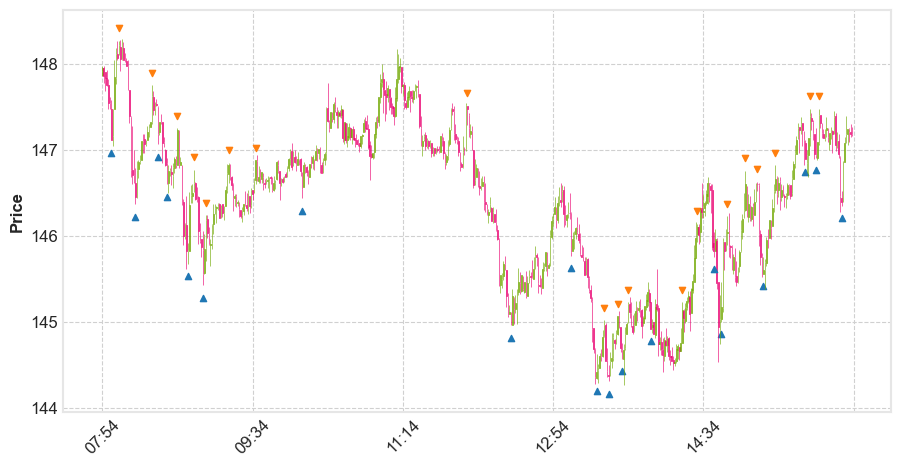

In [118]:
apds = [
    mpf.make_addplot(long_signal[-500:],type='scatter',markersize=20,marker='^'),
    mpf.make_addplot(short_signal[-500:],type='scatter',markersize=20,marker='v')
]

mpf.plot(data.tail(500), figratio=(16, 8), type="candle", volume=False, tight_layout=False, style="binance", addplot=apds)

In [119]:
data['signal'] = np.where(np.isnan(long_signal), 0, 1) + np.where(np.isnan(short_signal), 0, -1)

In [120]:
trader = Trader(account_size=10, leverage=50, fixed_margin=False, margin=0.1)

stoploss = None
rr = 1.5
tp_ratio = 0.004
tp = None

tp_count = 0
stoploss_count = 0

for idx, d in data.iterrows():
    if d.signal == -1:
        # short
        
        if trader.position != None:
            if trader.position == 'short' and trader.entry_price < d.Close:
                tp_count += 1
            elif trader.position == 'short' and trader.entry_price > d.Close:
                stoploss_count += 1
            elif trader.position == 'long' and trader.entry_price > d.Close:
                tp_count += 1
            else:
                stoploss_count += 1
            
            trader.close_pos(d.Close, tp=tp, stoploss=stoploss, exit_date=idx)
        
        trader.open_pos(d.Close, 'short', entry_date = idx)
        
        stoploss = d.Close * (1 + (tp_ratio / rr))
        tp = d.Close * (1 - tp_ratio)
        
    elif d.signal == 1:
        # long
        if trader.position != None:
            if trader.position == 'short' and trader.entry_price < d.Close:
                tp_count += 1
            elif trader.position == 'short' and trader.entry_price > d.Close:
                stoploss_count += 1
            elif trader.position == 'long' and trader.entry_price > d.Close:
                tp_count += 1
            else:
                stoploss_count += 1
                
            trader.close_pos(d.Close, tp=tp, stoploss=stoploss, exit_date=idx)
            
        trader.open_pos(d.Close, 'long', entry_date = idx)
        
        stoploss = d.Close * (1 - (tp_ratio / rr))
        tp = d.Close * (1 + tp_ratio)   
    
    elif d.signal == 0:
        if trader.position == 'short':
            if d.High >= stoploss or d.Low <= tp:
                trader.close_pos(stoploss if d.High >= stoploss else tp, tp=tp, stoploss=stoploss, exit_date=idx)

                if d.High >= stoploss:
                    stoploss_count += 1
                elif d.Low <= tp:
                    tp_count += 1

                stoploss = None
                tp = None
        elif trader.position == 'long':
            if d.Low <= stoploss or d.High >= tp:
                trader.close_pos(stoploss if d.Low <= stoploss else tp, tp=tp, stoploss=stoploss, exit_date=idx)

                if d.Low <= stoploss:
                    stoploss_count += 1
                elif d.High >= tp:
                    tp_count += 1

                stoploss = None
                tp = None

    if trader.position != None:
        if trader.is_liquidated(d.Close):
            print('liquidated')
            break


In [121]:
result = pd.DataFrame(trader.history).set_index('entry_date')

win = result[result.percentage > 0]
print('TP count : ', tp_count)
print('SL count : ', stoploss_count)
print('Win rate : {:.2f}%'.format((len(win) / len(result) * 100)))
print('Long win rate : {:.2f}%'.format(len(win[win.position == 'long']) / len(win) * 100))
print('Short win rate : {:.2f}%'.format(len(win[win.position == 'short']) / len(win) * 100))

TP count :  57
SL count :  32
Win rate : 68.54%
Long win rate : 54.10%
Short win rate : 45.90%


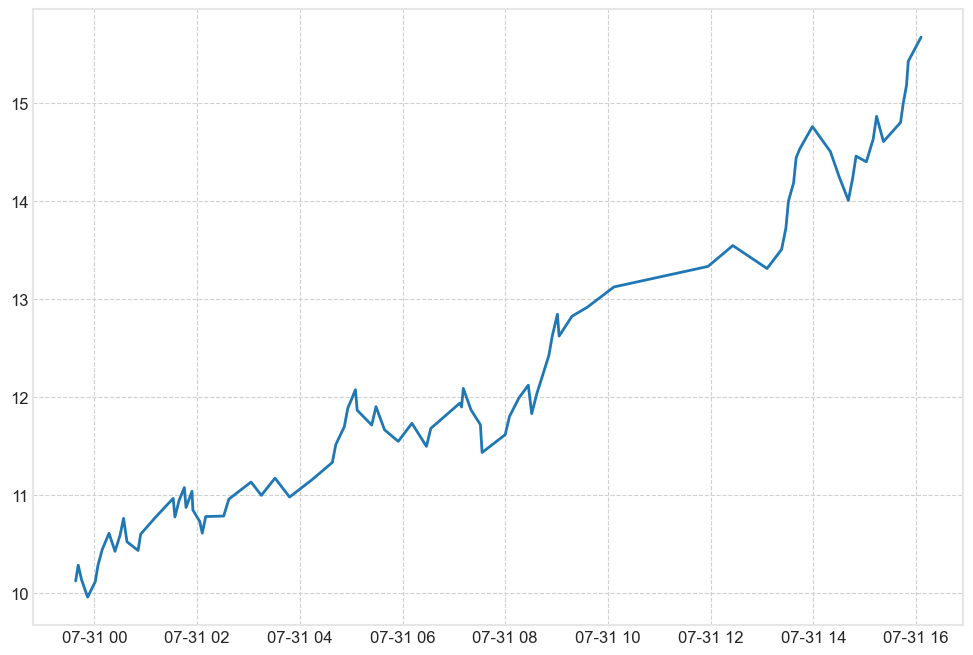

In [122]:
plt.figure(figsize=(12,8))
plt.plot(result.account_size)

In [123]:
data[data.signal!=0]

,Open,High,Low,Close,Volume,signal
Open time,,,,,,
2022-07-30 23:38:00,144.279999,144.470001,144.220001,144.399994,412.757996,-1
2022-07-30 23:41:00,143.910004,143.970001,143.639999,143.940002,986.174988,1
2022-07-30 23:45:00,144.520004,144.720001,144.460007,144.720001,451.459991,-1
2022-07-30 23:52:00,144.779999,145.029999,144.729996,145.029999,422.196991,-1
2022-07-31 00:01:00,145.669998,145.979996,145.529999,145.660004,1367.129028,-1
...,...,...,...,...,...,...
2022-07-31 15:42:00,147.080002,147.110001,146.889999,146.889999,154.778000,1
2022-07-31 15:45:00,147.149994,147.479996,147.050003,147.399994,771.289001,-1
2022-07-31 15:49:00,146.940002,147.259995,146.910004,146.910004,510.070007,1


In [124]:
result

,entry_price,position,entry_margin,entry_fee,number_contract,exit_price,profit,percentage,exit_fee,account_size,tp,stoploss,exit_date
entry_date,,,,,,,,,,,,,
2022-07-30 23:38:00,144.399994,short,1.000000,0.020000,0.346260,143.940002,0.159277,0.159277,0.020000,10.119277,143.822394,144.785061,2022-07-30 23:41:00
2022-07-30 23:41:00,143.940002,long,1.011928,0.020239,0.351510,144.515762,0.202386,0.200000,0.020239,10.281185,144.515762,143.556162,2022-07-30 23:44:00
2022-07-30 23:45:00,144.720001,short,1.028119,0.020562,0.355210,145.029999,-0.110114,-0.107103,0.020562,10.129946,144.141121,145.105921,2022-07-30 23:52:00
2022-07-30 23:52:00,145.029999,short,1.012995,0.020260,0.349236,145.416745,-0.135066,-0.133333,0.020260,9.954361,144.449879,145.416745,2022-07-31 00:00:00
2022-07-31 00:01:00,145.660004,short,0.995436,0.019909,0.341698,145.077364,0.199087,0.200000,0.019909,10.113630,145.077364,146.048430,2022-07-31 00:02:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31 15:42:00,146.889999,long,1.461043,0.029221,0.497325,147.399994,0.253633,0.173597,0.029221,14.805618,147.477559,146.498293,2022-07-31 15:45:00
2022-07-31 15:45:00,147.399994,short,1.480562,0.029611,0.502226,146.910004,0.246086,0.166211,0.029611,14.992482,146.810394,147.793061,2022-07-31 15:49:00
2022-07-31 15:49:00,146.910004,long,1.499248,0.029985,0.510261,147.410004,0.255130,0.170172,0.029985,15.187642,147.497644,146.518244,2022-07-31 15:51:00


## Param tuning

In [572]:
length = 500
bandwitdhs = np.arange(2,10)
multiples = np.arange(2,8)
history = []


for bandwitdh in bandwitdhs:
    for multiple in tqdm(multiples):

        data_paths = glob.glob('data/2022/*/ethusdt.{timeframe}*'.format(timeframe='15min'))
        data = pd.read_csv(data_paths[-1], index_col='Open time', usecols=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume'])

        data.index = pd.to_datetime(data.index)
        data = data.astype({'Open':'float32', 'High':'float32', 'Low':'float32', 'Close':'float32', 'Volume': 'float32'})

        data = data.tail(length)
        olhc = data.values[::-1]
        src = data.Close.values[::-1]

        long_signal = [np.nan]
        short_signal = [np.nan]

        y = []
        sum_e = 0
        for i in range(length):
            s = 0
            sw = 0

            for j in range(length):
                w = math.exp(-math.pow(i-j, 2) / (bandwitdh*bandwitdh*2))
                s += src[j] * w
                sw += w

            y2 = s / sw
            sum_e += abs(src[i] - y2)
            y.append(y2)

        mae = sum_e / length * multiple

        for i in range(1, length-1):
            y2 = y[i]
            y1 = y[i-1]

            if src[i] > y1 + mae and src[i+1] < y1 + mae:
                short_signal.append(olhc[i][1] * 1.001)
                long_signal.append(np.nan)
                continue

            if src[i] < y1 - mae and src[i+1] > y1 - mae:
                long_signal.append(olhc[i][2] * 0.999)
                short_signal.append(np.nan)
                continue

            long_signal.append(np.nan)
            short_signal.append(np.nan)
            
        long_signal.append(np.nan)
        short_signal.append(np.nan)
        long_signal = long_signal[::-1]
        short_signal = short_signal[::-1]

        data['signal'] = np.where(np.isnan(long_signal), 0, 1) + np.where(np.isnan(short_signal), 0, -1)

        trader = Trader(leverage=20, fixed_margin=False, margin=0.1)

        stoploss = None
        rr = 1.5
        tp_ratio = 0.01
        tp = None

        tp_count = 0
        stoploss_count = 0

        for idx, d in data.iterrows():
            if d.signal == -1:
                # short

                if trader.position != None:
                    if trader.position == 'short' and trader.entry_price < d.Close:
                        tp_count += 1
                    elif trader.position == 'short' and trader.entry_price > d.Close:
                        stoploss_count += 1
                    elif trader.position == 'long' and trader.entry_price > d.Close:
                        tp_count += 1
                    else:
                        stoploss_count += 1

                    trader.close_pos(d.Close, tp=tp, stoploss=stoploss, exit_date=idx)

                trader.open_pos(d.Close, 'short', entry_date = idx)

                stoploss = d.Close * (1 + (tp_ratio / rr))
                tp = d.Close * (1 - tp_ratio)

            elif d.signal == 1:
                # long
                if trader.position != None:
                    if trader.position == 'short' and trader.entry_price < d.Close:
                        tp_count += 1
                    elif trader.position == 'short' and trader.entry_price > d.Close:
                        stoploss_count += 1
                    elif trader.position == 'long' and trader.entry_price > d.Close:
                        tp_count += 1
                    else:
                        stoploss_count += 1

                    trader.close_pos(d.Close, tp=tp, stoploss=stoploss, exit_date=idx)

                trader.open_pos(d.Close, 'long', entry_date = idx)

                stoploss = d.Close * (1 - (tp_ratio / rr))
                tp = d.Close * (1 + tp_ratio)   

            elif d.signal == 0:
                if trader.position == 'short':
                    if d.High >= stoploss or d.Low <= tp:
                        trader.close_pos(stoploss if d.High >= stoploss else tp, tp=tp, stoploss=stoploss, exit_date=idx)

                        if d.High >= stoploss:
                            stoploss_count += 1
                        elif d.Low <= tp:
                            tp_count += 1

                        stoploss = None
                        tp = None
                elif trader.position == 'long':
                    if d.Low <= stoploss or d.High >= tp:
                        trader.close_pos(stoploss if d.Low <= stoploss else tp, tp=tp, stoploss=stoploss, exit_date=idx)

                        if d.Low <= stoploss:
                            stoploss_count += 1
                        elif d.High >= tp:
                            tp_count += 1

                        stoploss = None
                        tp = None

            if trader.position != None:
                if trader.is_liquidated(d.Close):
                    print('liquidated')
                    break
        history.append([bandwitdh, multiple, trader.account_size])
    print('Maximum percentage = ', np.max(np.array(history)[:, 2]))

  0%|          | 0/6 [00:00<?, ?it/s]

Maximum percentage =  181.39880005733414


  0%|          | 0/6 [00:00<?, ?it/s]

Maximum percentage =  181.39880005733414


  0%|          | 0/6 [00:00<?, ?it/s]

Maximum percentage =  181.39880005733414


  0%|          | 0/6 [00:00<?, ?it/s]

Maximum percentage =  181.39880005733414


  0%|          | 0/6 [00:00<?, ?it/s]

Maximum percentage =  181.39880005733414


  0%|          | 0/6 [00:00<?, ?it/s]

Maximum percentage =  181.39880005733414


  0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [573]:
h = pd.DataFrame(history)
h = h[h[2] > 100]
h.sort_values(2, ascending=False).head(30)

,0,1,2
0,2,2,181.398800
6,3,2,165.138524
12,4,2,161.124043
18,5,2,147.172735
24,6,2,138.804432
13,4,3,129.079558
1,2,3,128.491845
19,5,3,128.220957
30,7,2,125.425146
7,3,3,124.457390


In [544]:
lengths = np.arange(300, 2001, 100)
bandwitdh = 2
multiple = 2
history = []

for length in tqdm(lengths):
    data_paths = glob.glob('data/2022/*/ethusdt.{timeframe}*'.format(timeframe='5min'))
    data = pd.read_csv(data_paths[-1], index_col='Open time', usecols=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume'])

    data.index = pd.to_datetime(data.index)
    data = data.astype({'Open':'float32', 'High':'float32', 'Low':'float32', 'Close':'float32', 'Volume': 'float32'})

    data = data.tail(length)
    olhc = data.values[::-1]
    src = data.Close.values[::-1]

    long_signal = [np.nan]
    short_signal = [np.nan]

    y = []
    sum_e = 0
    for i in range(length):
        s = 0
        sw = 0

        for j in range(length):
            w = math.exp(-math.pow(i-j, 2) / (bandwitdh*bandwitdh*2))
            s += src[j] * w
            sw += w

        y2 = s / sw
        sum_e += abs(src[i] - y2)
        y.append(y2)

    mae = sum_e / length * multiple

    for i in range(1, length-1):
        y2 = y[i]
        y1 = y[i-1]

        if src[i] > y1 + mae and src[i+1] < y1 + mae:
            short_signal.append(olhc[i][1] * 1.001)
            long_signal.append(np.nan)
            continue

        if src[i] < y1 - mae and src[i+1] > y1 - mae:
            long_signal.append(olhc[i][2] * 0.999)
            short_signal.append(np.nan)
            continue

        long_signal.append(np.nan)
        short_signal.append(np.nan)

    long_signal.append(np.nan)
    short_signal.append(np.nan)
    long_signal = long_signal[::-1]
    short_signal = short_signal[::-1]

    data['signal'] = np.where(np.isnan(long_signal), 0, 1) + np.where(np.isnan(short_signal), 0, -1)

    trader = Trader(leverage=20, fixed_margin=False, margin=0.1)

    stoploss = None
    rr = 1.5
    tp_ratio = 0.01
    tp = None

    tp_count = 0
    stoploss_count = 0

    for idx, d in data.iterrows():
        if d.signal == -1:
            # short

            if trader.position != None:
                if trader.position == 'short' and trader.entry_price < d.Close:
                    tp_count += 1
                elif trader.position == 'short' and trader.entry_price > d.Close:
                    stoploss_count += 1
                elif trader.position == 'long' and trader.entry_price > d.Close:
                    tp_count += 1
                else:
                    stoploss_count += 1

                trader.close_pos(d.Close, tp=tp, stoploss=stoploss, exit_date=idx)

            trader.open_pos(d.Close, 'short', entry_date = idx)

            stoploss = d.Close * (1 + (tp_ratio / rr))
            tp = d.Close * (1 - tp_ratio)

        elif d.signal == 1:
            # long
            if trader.position != None:
                if trader.position == 'short' and trader.entry_price < d.Close:
                    tp_count += 1
                elif trader.position == 'short' and trader.entry_price > d.Close:
                    stoploss_count += 1
                elif trader.position == 'long' and trader.entry_price > d.Close:
                    tp_count += 1
                else:
                    stoploss_count += 1

                trader.close_pos(d.Close, tp=tp, stoploss=stoploss, exit_date=idx)

            trader.open_pos(d.Close, 'long', entry_date = idx)

            stoploss = d.Close * (1 - (tp_ratio / rr))
            tp = d.Close * (1 + tp_ratio)   

        elif d.signal == 0:
            if trader.position == 'short':
                if d.High >= stoploss or d.Low <= tp:
                    trader.close_pos(stoploss if d.High >= stoploss else tp, tp=tp, stoploss=stoploss, exit_date=idx)

                    if d.High >= stoploss:
                        stoploss_count += 1
                    elif d.Low <= tp:
                        tp_count += 1

                    stoploss = None
                    tp = None
            elif trader.position == 'long':
                if d.Low <= stoploss or d.High >= tp:
                    trader.close_pos(stoploss if d.Low <= stoploss else tp, tp=tp, stoploss=stoploss, exit_date=idx)

                    if d.Low <= stoploss:
                        stoploss_count += 1
                    elif d.High >= tp:
                        tp_count += 1

                    stoploss = None
                    tp = None

        if trader.position != None:
            if trader.is_liquidated(d.Close):
                print('liquidated')
                break
    history.append([length, trader.account_size])
print('Maximum percentage = ', np.max(np.array(history)[:, 1]))

  0%|          | 0/18 [00:00<?, ?it/s]

Maximum percentage =  702.7396909885857


In [545]:
h = pd.DataFrame(history)
h = h[h[1] > 100]
h.sort_values(1, ascending=False).head(30)

,0,1
17,2000,702.739691
16,1900,685.758858
15,1800,610.709361
14,1700,560.989297
13,1600,494.372911
12,1500,406.681126
11,1400,365.139584
10,1300,315.619250
9,1200,283.893296
8,1100,241.218348


## Live Trading

In [67]:
import datetime
import requests
import time
import math
import glob
import pandas as pd
import mplfinance as mpf
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from Trader import Trader
from binance.client import Client

binance_apikey = 'WaqFzORzir8JMrOl6NR6gk3UX1wuSjBBlk3kybK6YoGwtzEZTVV46oXMH2cp91aT'
binance_apisecret = 'ZQGq05oyxTCH3K4PiMxCHFA05MHhd7cwtB3OWDysy4tghQn5EJDLmVU1EptXFuzS'
client = Client(binance_apikey, binance_apisecret)
info = client.futures_exchange_info()

columns = ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 
           'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']

In [140]:
def is_in_position(symbol):
    positions = client.futures_position_information(symbol=symbol)
    if float(positions[0]['positionAmt']) != 0:
        return True
    return False

def get_margin():
    for balance in client.futures_account_balance():
        if balance['asset'] == 'USDT':
            return float(balance['balance']) * MARGIN_RATIO
        
def get_price_precision(symbol):
    for x in info['symbols']:
        if x['symbol'].lower() == symbol.lower():
            return x['pricePrecision']
        
def get_quantity_precision(symbol):
    for x in info['symbols']:
        if x['symbol'].lower() == symbol.lower():
            return x['quantityPrecision']

def get_minimum_entry(symbol):
    for x in info['symbols']:
        if x['symbol'].lower() == symbol.lower():
            return float(x['filters'][1]['minQty'])

def get_quantity(price, entry_margin, leverage):
    return (entry_margin * leverage) / price

def close_all_orders(symbol):
    orders = client.futures_cancel_all_open_orders(symbol=symbol)

def close_opening_position(symbol):
    for pos in client.futures_acount()['positions']:
        if pos['symbol'] == symbol and pos['positionAmt'] != 0:
            quantity = float(pos['positionAmt'])
            client.futures_create_order(symbol=symbol, side=Client.SIDE_BUY if quantity < 0 else Client.SIDE_SELL , quantity=abs(quantity), type=Client.FUTURE_ORDER_TYPE_MARKET)
            break

def open_limit_order(symbol, entry, position, quantity, reduceOnly=False):
    side = Client.SIDE_BUY if position == 'long' else Client.SIDE_SELL
    res = client.futures_create_order(symbol=symbol, side=side, type=Client.FUTURE_ORDER_TYPE_LIMIT, timeInForce=Client.TIME_IN_FORCE_GTC, quantity=quantity, price=entry, reduceOnly=reduceOnly)

def open_tp_order(symbol, entry, stopPrice, position, quantity):
    side = Client.SIDE_BUY if position == 'long' else Client.SIDE_SELL
    res = client.futures_create_order(symbol=symbol, side=side, type=Client.FUTURE_ORDER_TYPE_STOP, timeInForce=Client.TIME_IN_FORCE_GTC, quantity=quantity, price=entry, stopPrice=stopPrice, reduceOnly=True)

def open_market_order(symbol, position, quantity):
    side = Client.SIDE_BUY if position == 'long' else Client.SIDE_SELL
    res = client.futures_create_order(symbol=symbol, side=side, type=Client.FUTURE_ORDER_TYPE_MARKET, quantity=quantity)

def set_leverage(symbol, leverage, timestamp):
    client.futures_change_leverage(symbol=symbol, leverage=leverage, timestamp=timestamp)

def open_stoploss_order(symbol, entry, position):
    side = Client.SIDE_BUY if position == 'long' else Client.SIDE_SELL
    res = client.futures_create_order(symbol=symbol, side=side, type=Client.FUTURE_ORDER_TYPE_STOP_MARKET, stopPrice=entry, closePosition=True)


In [144]:
#https://stackoverflow.com/questions/51358147/fetch-candlestick-kline-data-from-binance-api-using-python-preferably-requests
interval = 5 # minute
pair = 'BCHUSDT'
tick_interval = '5m'
limit = 1000
url = 'https://fapi.binance.com/fapi/v1/klines?symbol='+ pair + '&interval=' + tick_interval + '&limit=' + str(limit)

data = requests.get(url).json()[:-1]
data = pd.DataFrame(data, columns=columns).set_index('Open time')
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.index = pd.to_datetime(data.index, unit='ms')
data = data.astype({'Open':'float32', 'High':'float32', 'Low':'float32', 'Close':'float32', 'Volume': 'float32'})

limit = 2
url = 'https://fapi.binance.com/fapi/v1/klines?symbol='+ pair + '&interval=' + tick_interval + '&limit=' + str(limit)

In [147]:
MARGIN_RATIO = 0.1 # percentage
LEVERAGE = 50
tp_ratio = 0.007
rr = 1.5

length = 500
bandwitdh = 2
multiple = 2

In [148]:
position = None
while True:
    ##########################################
    # Wait new candle
    ##########################################

    second = datetime.datetime.now().second
    minute = datetime.datetime.now().minute
    
    sleep_time = (interval - (minute % interval)) * 60 - second + 1
    print(sleep_time)
    for i in range(sleep_time, 0, -1):
        print('\r{i}'.format(i=i), end='')
        time.sleep(1)

    ##########################################
    # Get new candle
    ##########################################

    tmp_data = requests.get(url).json()[0]
    tmp_df = pd.DataFrame([tmp_data], columns=columns).set_index('Open time')
    tmp_df = tmp_df[['Open', 'High', 'Low', 'Close', 'Volume']]
    tmp_df.index = pd.to_datetime(tmp_df.index, unit='ms')
    tmp_df = tmp_df.astype({'Open':'float32', 'High':'float32', 'Low':'float32', 'Close':'float32', 'Volume': 'float32'})
    
    data = pd.concat([data, tmp_df]).tail(length)
    
    ##########################################
    # Compute
    ##########################################

    src = data.Close.values[::1]

    signal = [np.nan]

    y = []
    sum_e = 0
    for i in tqdm(range(length)):
        s = 0
        sw = 0

        for j in range(length):
            w = math.exp(-math.pow(i-j, 2) / (bandwitdh*bandwitdh*2))
            s += src[j] * w
            sw += w

        y2 = s / sw
        sum_e += abs(src[i] - y2)
        y.append(y2)

    mae = sum_e / length * multiple

    for i in range(1, length-1):
        y2 = y[i]
        y1 = y[i-1]

        if src[i] > y1 + mae and src[i+1] < y1 + mae:
            signal.append(-1)
            continue

        if src[i] < y1 - mae and src[i+1] > y1 - mae:
            signal.append(1)
            continue

        signal.append(np.nan)

    signal.append(np.nan)
#     signal = signal[::-1]

    if signal[-2] == 1:
        position = 'long'
        entry_price = data.iloc[-1].Close
    elif signal[-2] == -1:
        position = 'short'
        entry_price = data.iloc[-1].Close
    print(signal[-10:])
    ##########################################
    # Create order
    ##########################################
    if not np.isnan(signal[-2]):
        if not is_in_position(pair):
            print('Open order')

            close_all_orders(pair)
            if position == 'short':
                stoploss = entry_price * (1 + (tp_ratio / rr))
                tp = entry_price * (1 - tp_ratio)
            elif position == 'long':
                stoploss = entry_price * (1 - (tp_ratio / rr))
                tp = entry_price * (1 + tp_ratio)

            set_leverage(pair, LEVERAGE, time.time())
            quantity = round(get_quantity(entry_price, get_margin(), LEVERAGE), get_quantity_precision(pair))
            tp = round(tp, get_price_precision(pair))
            stoploss = round(stoploss, get_price_precision(pair))

            open_market_order(pair, position, quantity) # entry (market order??)
            open_limit_order(pair, tp, 'short' if position == 'long' else 'long', quantity, reduceOnly=True) # tp
            open_stoploss_order(pair, stoploss, 'short' if position == 'long' else 'long') # stoploss

            print()
            print('-----------------------')
            print(pair)
            print('Entry : ', entry_price)
            print('TP : ', tp)
            print('Stoploss : ', stoploss)
            print('-----------------------')

        elif is_in_position(pair):
            print('Close old order and open new order')
            close_opening_position(pair)
            close_all_orders(pair)

            if position == 'short':
                stoploss = entry_price * (1 + (tp_ratio / rr))
                tp = entry_price * (1 - tp_ratio)
            elif position == 'long':
                stoploss = entry_price * (1 - (tp_ratio / rr))
                tp = entry_price * (1 + tp_ratio)

            set_leverage(pair, LEVERAGE, time.time())
            quantity = round(get_quantity(entry_price, get_margin(), LEVERAGE), get_quantity_precision(pair))
            tp = round(tp, get_price_precision(pair))
            stoploss = round(stoploss, get_price_precision(pair))

            open_market_order(pair, position, quantity) # entry (market order or limit order??)
            open_limit_order(pair, tp, 'short' if position == 'long' else 'long', quantity, reduceOnly=True) # tp
            open_stoploss_order(pair, stoploss, 'short' if position == 'long' else 'long') # stoploss

            print()
            print('-----------------------')
            print(pair)
            print('Entry : ', entry_price)
            print('TP : ', tp)
            print('Stoploss : ', stoploss)
            print('-----------------------')


110
100

  0%|          | 0/500 [00:00<?, ?it/s]

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
298
100

  0%|          | 0/500 [00:00<?, ?it/s]

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
296
100

  0%|          | 0/500 [00:00<?, ?it/s]

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
297
100

  0%|          | 0/500 [00:00<?, ?it/s]

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
296
100

  0%|          | 0/500 [00:00<?, ?it/s]

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
296
100

  0%|          | 0/500 [00:00<?, ?it/s]

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
297
100

  0%|          | 0/500 [00:00<?, ?it/s]

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
296
256

KeyboardInterrupt: 

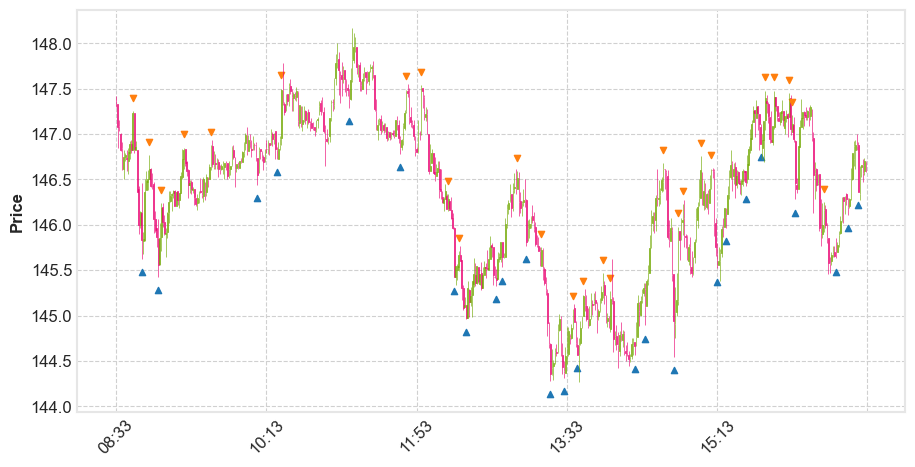

In [89]:
short_signal = np.where(np.array(signal) == -1, 1, np.nan) * data.High.values * 1.001
long_signal = np.where(np.array(signal) == 1, 1, np.nan) * data.Low.values * 0.999

apds = [
    mpf.make_addplot(long_signal[-500:],type='scatter',markersize=20,marker='^'),
    mpf.make_addplot(short_signal[-500:],type='scatter',markersize=20,marker='v')
]

mpf.plot(data.tail(500), figratio=(16, 8), type="candle", volume=False, tight_layout=False, style="binance", addplot=apds)